# PyMC3 example

In [1]:
import pymc3 as pm
import numpy as np

import theano
# import theano.tensor as tt

Utility function(s)

In [2]:
def marginal_distributions(trace, names):
    """Samples from the prior.
    trace = samples from prior
    names = list of strings of node names
    """
    for name in names:
        print(f"P({name}) = {trace[name].mean()*100:.2f}%")

In [3]:
def conditional_probabilities(trace, names, evidence):
    """Output the probabilities of all the variables, conditioned on the evidence.
    trace = samples from prior
    names = list of strings of node names
    evidence = {'norman_late': 1, 'martin_late': 1} (for example)
    """
    
    n_samples = len(list(trace.values())[0])
    
    for name in names:

        # Calculate Boolean subset of samples confiorming to the evidence
        subset = np.full(n_samples, True, dtype=bool)
        for key, val in evidence.items():
            subset = (subset) & (trace[key] == val)

        # Calculate mean of variable of interest consistent with the evidence
        prob = trace[name][subset == 1].mean()

        # Compose string
        string = f"P({name} | "
        for key, value in evidence.items():
            string += key + f" = {value}"
            string += ", "
        string = string[:-2]
        string += f") = {prob*100:.2f}%"
        
        print(string)

## Example: smoking / covid
PyMC3 implimentation provided by Junpeng Lao, see https://discourse.pymc.io/t/bayes-nets-belief-networks-and-pymc/5150/2?u=drbenvincent. The 'trick' here seems to be to generate a PyMC3 model with no observed data, sample from the prior, then look up the probability of interest conditional upon nodes taking on certain values.

In [4]:
lookup_table = theano.shared(np.asarray([
    [[.99, .01], [.1, .9]],
    [[.9, .1], [.1, .9]]]))

def f(smoker, covid):
    return lookup_table[smoker, covid]

names = ["smoker", "covid", "hospital"]

with pm.Model() as m:
    smoker = pm.Categorical('smoker', [.75, .25])
    covid = pm.Categorical('covid', [.9, .1])
    hospital = pm.Categorical('hospital', f(smoker, covid))
    prior = pm.sample_prior_predictive(100000)

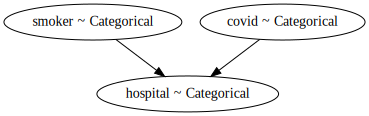

In [5]:
pm.model_to_graphviz(m)

In [6]:
marginal_distributions(prior, ["smoker", "covid", "hospital"])

P(smoker) = 25.00%
P(covid) = 10.01%
P(hospital) = 11.94%


In [7]:
conditional_probabilities(prior, ["smoker"], {'hospital': 1, 'covid': 1})

P(smoker | hospital = 1, covid = 1) = 24.57%


In [8]:
conditional_probabilities(prior, ["covid"], {'hospital': 1, 'smoker': 0})

P(covid | hospital = 1, smoker = 0) = 91.15%


In [9]:
conditional_probabilities(prior, ["covid"], {'hospital': 1, 'smoker': 1})

P(covid | hospital = 1, smoker = 1) = 49.59%


    predict_proba0 = prior['covid'][
        (prior['smoker'] == 0)
      & (prior['hospital'] == 1)].mean()

    predict_proba1 = prior['covid'][
        (prior['smoker'] == 1)
      & (prior['hospital'] == 1)].mean()

    print(f'P(covid|¬smoking, hospital) is {predict_proba0}')
    print(f'P(covid|smoking, hospital) is {predict_proba1}')

In [10]:
lookup_table[0,0].eval()

array([0.99, 0.01])

In [11]:
lookup_table[0,1].eval()

array([0.1, 0.9])

In [12]:
lookup_table[1,0].eval()

array([0.9, 0.1])

In [13]:
lookup_table[1,1].eval()

array([0.1, 0.9])

## Example 7.3 
From Risk Assessment and Decision Analysis with Bayesian Networks, by Fenton & Neil

In [14]:
# P(martin_late|train_strike, martin_oversleeps) -------------------------

martin_late_lookup = theano.shared(np.asarray([
    [[.7, .3], [.4, .6]],
    [[.4, .6], [.2, .8]]]))

def p_martin_late(train_strike, martin_oversleeps):
    return martin_late_lookup[train_strike, martin_oversleeps]

# P(norman_late|train_strike) --------------------------------------------
p_norman_late_lookup = theano.shared(np.asarray([[0.9, .1], [.2, .8]]))

def p_norman_late(train_strike):
    return p_norman_late_lookup[train_strike]

# Build model ------------------------------------------------------------
with pm.Model() as m:
    martin_oversleeps = pm.Categorical('martin_oversleeps', [.6, .4])
    train_strike = pm.Categorical('train_strike', [.9, .1])
    norman_late = pm.Categorical('norman_late', 
                                 p_norman_late(train_strike))
    martin_late = pm.Categorical('martin_late', 
                                 p_martin_late(train_strike, martin_oversleeps))
    prior = pm.sample_prior_predictive(500_000)

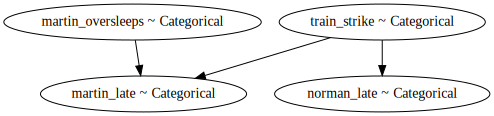

In [15]:
pm.model_to_graphviz(m)

In [16]:
names = ['martin_oversleeps', 'train_strike', 'martin_late', 'norman_late']

In [17]:
marginal_distributions(prior, names)

P(martin_oversleeps) = 39.96%
P(train_strike) = 9.97%
P(martin_late) = 44.55%
P(norman_late) = 17.02%


In [18]:
conditional_probabilities(prior, names, {'norman_late': 1})

P(martin_oversleeps | norman_late = 1) = 39.87%
P(train_strike | norman_late = 1) = 46.86%
P(martin_late | norman_late = 1) = 54.18%
P(norman_late | norman_late = 1) = 100.00%


In [19]:
conditional_probabilities(prior, names, {'martin_late': 1})

P(martin_oversleeps | martin_late = 1) = 55.54%
P(train_strike | martin_late = 1) = 15.18%
P(martin_late | martin_late = 1) = 100.00%
P(norman_late | martin_late = 1) = 20.69%


In [20]:
conditional_probabilities(prior, names, {'norman_late': 1, 'martin_late': 1})

P(martin_oversleeps | norman_late = 1, martin_late = 1) = 51.07%
P(train_strike | norman_late = 1, martin_late = 1) = 58.78%
P(martin_late | norman_late = 1, martin_late = 1) = 100.00%
P(norman_late | norman_late = 1, martin_late = 1) = 100.00%


### Marginal distributions

```python 
prior['martin_oversleeps'].mean()
prior['train_strike'].mean()
prior['martin_late'].mean()
prior['norman_late'].mean()
```

### Conditioning on Norman being late

```python 
prior['martin_oversleeps'][prior_trace['norman_late'] == 1].mean()
prior['train_strike'][prior_trace['norman_late'] == 1].mean()
prior['martin_late'][prior_trace['norman_late'] == 1].mean()
prior['norman_late'][prior_trace['norman_late'] == 1].mean()
```

### Conditioning on Norman being late and Martin being late

```python 
prior['martin_oversleeps'][(prior['martin_late'] == 1) & (prior['norman_late'] == 1)].mean()
prior['train_strike'][(prior['martin_late'] == 1) & (prior['norman_late'] == 1)].mean()
prior['martin_late'][(prior['martin_late'] == 1) & (prior['norman_late'] == 1)].mean()
prior['norman_late'][(prior['martin_late'] == 1) & (prior['norman_late'] == 1)].mean()

```